# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
import sys
print(sys.version)


3.8.0 (default, Nov  6 2019, 21:49:08) 
[GCC 7.3.0]


In [2]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes



config = {
    'function_family': {
        'maximum_depth': 4,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,    
        'dt_type': 'vanilla', #'vanilla', 'SDT'
    },
    'data': {
        'number_of_variables': 10, 
        'num_classes': 2,
        
        'function_generation_type': 'make_classification_vanilla_decision_tree_trained', # 'make_classification' 'random_decision_tree' 'random_decision_tree_trained' 'random_vanilla_decision_tree_trained' 'make_classification_vanilla_decision_tree_trained'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        #'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-2,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [256],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
        
        'number_of_lambda_weights': None,
        
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 10000,
    },     
    
    'i_net': {
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'dropout': [0.5, 0],
        
        'optimizer': 'adam', #adam
        'learning_rate': 0.001,
        'loss': 'binary_crossentropy',
        'metrics': ['binary_accuracy'],
        
        'epochs': 200, 
        'early_stopping': True,
        'batch_size': 256,

        'interpretation_dataset_size': 10000,
                
        'test_size': 50, #Float for fraction, Int for number 0
        
        'function_representation_type': 2, # 1=standard representation; 2=sparse representation

        'optimize_decision_function': True, #False
        'function_value_loss': True, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 50,
    },    
    
    'evaluation': {   
        #'inet_holdout_seed_evaluation': False,
            
        'random_evaluation_dataset_size': 500, 
        'per_network_optimization_dataset_size': 5000,

        'sklearn_dt_benchmark': False,
        'sdt_benchmark': False,
        
        'different_eval_data': False,
        
        'eval_data_description': {
            ######### data #########
            'eval_data_function_generation_type': 'make_classification',
            'eval_data_lambda_dataset_size': 5000, #number of samples per function
            'eval_data_noise_injected_level': 0, 
            'eval_data_noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'     
            ######### lambda_net #########
            'eval_data_number_of_trained_lambda_nets': 500,
            ######### i_net #########
            'eval_data_interpretation_dataset_size': 500,
            
        }
        
    },    
    
    'computation':{
        'load_model': False,
        
        'n_jobs': 20,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}


## Imports

In [3]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [4]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from itertools import product       
from tqdm.notebook import tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import shutil

import logging
from copy import deepcopy
#from prettytable import PrettyTable
#import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score, log_loss
from sklearn.tree import DecisionTreeClassifier, plot_tree



#from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import tensorflow as tf
#import tensorflow_addons as tfa
#import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns


import random 



from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output



In [5]:
tf.__version__

'2.4.3'

In [6]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [7]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################

config['i_net']['data_reshape_version'] = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if use_gpu else ''

#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1'

#os.environ['XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1' if use_gpu else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2, --tf_xla_enable_xla_devices' if use_gpu else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices


sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)
np.set_printoptions(suppress=True)



In [8]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
from utilities.DecisionTree_BASIC import *

#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
config['function_family']['basic_function_representation_length'] = (2 ** maximum_depth - 1) * number_of_variables + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes
config['function_family']['function_representation_length'] = ( 
       ((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes  if function_representation_type == 1 and dt_type == 'SDT'
  else (2 ** maximum_depth - 1) * decision_sparsity + (2 ** maximum_depth - 1) + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) * num_classes if function_representation_type == 2 and dt_type == 'SDT'
  else ((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth)  if function_representation_type == 1 and dt_type == 'vanilla'
  else (2 ** maximum_depth - 1) * decision_sparsity + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) if function_representation_type == 2 and dt_type == 'vanilla'
  else None
                                                            )
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)
#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='interpretation_net'))
create_folders_inet(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [9]:
print(path_identifier_interpretation_net)

print(path_identifier_lambda_net_data)


lNetSize5000_numLNets10000_var10_class2_make_classification_vanilla_decision_tree_trained_xMax1_xMin0_xDistuniform_depth4_beta1_decisionSpars1_fullyGrown/256_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42/inet_dense512-1024_drop0.5-0e200b256_adam
lNetSize5000_numLNets10000_var10_class2_make_classification_vanilla_decision_tree_trained_xMax1_xMin0_xDistuniform_depth4_beta1_decisionSpars1_fullyGrown/256_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42


In [10]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [11]:
def load_lambda_nets(config, no_noise=False, n_jobs=1):
    
    #def generate_lambda_net()
    
    #if psutil.virtual_memory().percent > 80:
        #raise SystemExit("Out of RAM!")
    
    if no_noise==True:
        config['noise_injected_level'] = 0
    path_dict = generate_paths(config, path_type='interpretation_net')        
        
    directory = './data/weights/' + 'weights_' + path_dict['path_identifier_lambda_net_data'] + '/'
    path_network_parameters = directory + 'weights' + '.txt'
    path_X_data = directory + 'X_test_lambda.txt'
    path_y_data = directory + 'y_test_lambda.txt'        
    
    network_parameters = pd.read_csv(path_network_parameters, sep=",", header=None)
    network_parameters = network_parameters.sort_values(by=0)
    if no_noise == False:
        network_parameters = network_parameters.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
    
    X_test_lambda = pd.read_csv(path_X_data, sep=",", header=None)
    X_test_lambda = X_test_lambda.sort_values(by=0)
    if no_noise == False:
        X_test_lambda = X_test_lambda.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
    
    y_test_lambda = pd.read_csv(path_y_data, sep=",", header=None)
    y_test_lambda = y_test_lambda.sort_values(by=0)
    if no_noise == False:
        y_test_lambda = y_test_lambda.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
        
        
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky

    lambda_nets = parallel(delayed(LambdaNet)(network_parameters_row, 
                                              X_test_lambda_row, 
                                              y_test_lambda_row, 
                                              config) for network_parameters_row, X_test_lambda_row, y_test_lambda_row in zip(network_parameters.values, X_test_lambda.values, y_test_lambda.values))          
    del parallel
    
    base_model = generate_base_model(config)  
    
    def initialize_network_wrapper(config, lambda_net, base_model):
        lambda_net.initialize_network(config, base_model)
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='sequential')
    _ = parallel(delayed(initialize_network_wrapper)(config, lambda_net, base_model) for lambda_net in lambda_nets)   
    del parallel
    
    def initialize_target_function_wrapper(config, lambda_net):
        lambda_net.initialize_target_function(config)
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='sequential')
    _ = parallel(delayed(initialize_target_function_wrapper)(config, lambda_net) for lambda_net in lambda_nets)   
    del parallel
        
    
    #lambda_nets = [None] * network_parameters.shape[0]
    #for i, (network_parameters_row, X_test_lambda_row, y_test_lambda_row) in tqdm(enumerate(zip(network_parameters.values, X_test_lambda.values, y_test_lambda.values)), total=network_parameters.values.shape[0]):        
    #    lambda_net = LambdaNet(network_parameters_row, X_test_lambda_row, y_test_lambda_row, config)
    #    lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [12]:
#LOAD DATA
if different_eval_data:
    config_train = deepcopy(config)
    config_eval = deepcopy(config)
    
    config_eval['data']['function_generation_type'] = config['evaluation']['eval_data_description']['eval_data_function_generation_type']
    config_eval['data']['lambda_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_lambda_dataset_size']
    config_eval['data']['noise_injected_level'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_level']
    config_eval['data']['noise_injected_type'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_type'] 
    config_eval['lambda_net']['number_of_trained_lambda_nets'] = config['evaluation']['eval_data_description']['eval_data_number_of_trained_lambda_nets']   
    config_eval['i_net']['interpretation_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_interpretation_dataset_size']   
    

    lambda_net_dataset_train = load_lambda_nets(config_train, n_jobs=n_jobs)
    lambda_net_dataset_eval = load_lambda_nets(config_eval, n_jobs=n_jobs)

    lambda_net_dataset_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset_eval, test_split=test_size)    
else:
    lambda_net_dataset = load_lambda_nets(config, n_jobs=n_jobs)

    lambda_net_dataset_train_with_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
    lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset_train_with_valid, test_split=0.1)    

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  88 tasks      | elapsed:    6.2s
[Parallel(n_jobs=20)]: Done 1108 tasks      | elapsed:    7.2s
[Parallel(n_jobs=20)]: Done 4692 tasks      | elapsed:    9.9s
[Parallel(n_jobs=20)]: Done 9300 tasks      | elapsed:   13.1s
[Parallel(n_jobs=20)]: Done 10000 out of 10000 | elapsed:   13.5s finished
[Parallel(n_jobs=20)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done 10000 out of 10000 | elapsed:  3.6min finished
[Parallel(n_jobs=20)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done 10000 

## Data Inspection

In [13]:
lambda_net_dataset_train.shape

(8955, 3272)

In [14]:
lambda_net_dataset_valid.shape

(995, 3272)

In [15]:
lambda_net_dataset_test.shape

(50, 3272)

In [16]:
lambda_net_dataset_train.as_pandas(config).head()

,index,seed,f0v0,f0v1,f0v2,f0v3,f0v4,f0v5,f0v6,f0v7,f0v8,f0v9,f1v0,f1v1,f1v2,f1v3,f1v4,f1v5,f1v6,f1v7,f1v8,f1v9,f2v0,f2v1,f2v2,f2v3,f2v4,f2v5,f2v6,f2v7,f2v8,f2v9,f3v0,f3v1,f3v2,f3v3,f3v4,f3v5,f3v6,f3v7,f3v8,f3v9,f4v0,f4v1,f4v2,f4v3,f4v4,f4v5,f4v6,f4v7,f4v8,f4v9,f5v0,f5v1,f5v2,f5v3,f5v4,f5v5,f5v6,f5v7,f5v8,f5v9,f6v0,f6v1,f6v2,f6v3,f6v4,f6v5,f6v6,f6v7,f6v8,f6v9,f7v0,f7v1,f7v2,f7v3,f7v4,f7v5,f7v6,f7v7,f7v8,f7v9,f8v0,f8v1,f8v2,f8v3,f8v4,f8v5,f8v6,f8v7,f8v8,f8v9,f9v0,f9v1,f9v2,f9v3,f9v4,f9v5,f9v6,f9v7,...,wb_2973,wb_2974,wb_2975,wb_2976,wb_2977,wb_2978,wb_2979,wb_2980,wb_2981,wb_2982,wb_2983,wb_2984,wb_2985,wb_2986,wb_2987,wb_2988,wb_2989,wb_2990,wb_2991,wb_2992,wb_2993,wb_2994,wb_2995,wb_2996,wb_2997,wb_2998,wb_2999,wb_3000,wb_3001,wb_3002,wb_3003,wb_3004,wb_3005,wb_3006,wb_3007,wb_3008,wb_3009,wb_3010,wb_3011,wb_3012,wb_3013,wb_3014,wb_3015,wb_3016,wb_3017,wb_3018,wb_3019,wb_3020,wb_3021,wb_3022,wb_3023,wb_3024,wb_3025,wb_3026,wb_3027,wb_3028,wb_3029,wb_3030,wb_3031,wb_3032,wb_3033,wb_3034,wb_3035,wb_3036,wb_3037,wb_3038,wb_3039,wb_3040,wb_3041,wb_3042,wb_3043,wb_3044,wb_3045,wb_3046,wb_3047,wb_3048,wb_3049,wb_3050,wb_3051,wb_3052,wb_3053,wb_3054,wb_3055,wb_3056,wb_3057,wb_3058,wb_3059,wb_3060,wb_3061,wb_3062,wb_3063,wb_3064,wb_3065,wb_3066,wb_3067,wb_3068,wb_3069,wb_3070,wb_3071,wb_3072
8938,8938.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-1.762,0.475,-1.470,-0.074,-0.153,-0.116,0.070,0.030,0.216,-1.065,-0.748,0.223,-1.532,-0.112,-0.906,1.014,-0.084,-0.013,-0.259,-0.419,-1.127,1.710,-2.433,-1.290,-0.126,-1.404,0.829,0.170,-0.152,3.375,-0.042,0.244,-0.222,-1.568,0.756,0.062,-0.341,-1.643,0.074,0.076,0.241,-0.156,-0.322,0.533,-0.525,-0.019,1.318,0.586,-2.487,0.394,0.799,0.132,-0.021,0.891,-0.292,0.369,0.966,2.407,0.944,0.513,-0.332,-1.110,-0.267,0.619,0.451,-0.046,0.009,1.533,0.161,-1.083,2.560,-1.394,-0.053,1.796,-0.150,0.349,-0.861,0.550,0.029,-0.147,-1.518,-1.727,0.609,0.844,0.044,0.106,-0.090,-1.146,-0.118,-0.070,-0.114,0.151,0.754,0.572,-1.141,1.070,-0.742,-0.123,1.680,-0.173
3272,3272.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.125,-1.130,-0.055,-0.076,-0.156,-2.828,0.070,0.030,0.189,-0.102,-0.173,0.171,-0.635,-0.071,-0.039,0.019,-0.089,-3.584,-0.093,-0.137,-2.773,0.279,-1.841,-0.007,-0.126,-0.212,1.995,0.047,-0.152,0.131,-0.042,-1.298,-1.747,-2.486,-1.917,0.064,-0.718,-0.849,1.688,0.111,2.920,-0.262,-0.385,0.013,0.111,-0.011,1.352,2.042,-0.092,2.094,0.649,0.159,-0.066,0.184,-0.262,1.105,0.693,0.395,0.020,0.145,-1.172,-0.842,-0.319,1.652,0.101,-0.541,0.014,0.009,0.099,0.038,0.062,-0.059,-0.053,2.410,-0.150,0.631,-0.258,1.350,0.432,-0.147,-2.478,-0.012,0.076,0.907,0.050,0.294,-0.188,-0.163,-0.039,-0.070,-0.107,-1.642,0.253,0.810,-0.094,0.256,-0.074,-1.051,2.372,-0.004
3093,3093.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0

In [17]:
lambda_net_dataset_valid.as_pandas(config).head()

,index,seed,f0v0,f0v1,f0v2,f0v3,f0v4,f0v5,f0v6,f0v7,f0v8,f0v9,f1v0,f1v1,f1v2,f1v3,f1v4,f1v5,f1v6,f1v7,f1v8,f1v9,f2v0,f2v1,f2v2,f2v3,f2v4,f2v5,f2v6,f2v7,f2v8,f2v9,f3v0,f3v1,f3v2,f3v3,f3v4,f3v5,f3v6,f3v7,f3v8,f3v9,f4v0,f4v1,f4v2,f4v3,f4v4,f4v5,f4v6,f4v7,f4v8,f4v9,f5v0,f5v1,f5v2,f5v3,f5v4,f5v5,f5v6,f5v7,f5v8,f5v9,f6v0,f6v1,f6v2,f6v3,f6v4,f6v5,f6v6,f6v7,f6v8,f6v9,f7v0,f7v1,f7v2,f7v3,f7v4,f7v5,f7v6,f7v7,f7v8,f7v9,f8v0,f8v1,f8v2,f8v3,f8v4,f8v5,f8v6,f8v7,f8v8,f8v9,f9v0,f9v1,f9v2,f9v3,f9v4,f9v5,f9v6,f9v7,...,wb_2973,wb_2974,wb_2975,wb_2976,wb_2977,wb_2978,wb_2979,wb_2980,wb_2981,wb_2982,wb_2983,wb_2984,wb_2985,wb_2986,wb_2987,wb_2988,wb_2989,wb_2990,wb_2991,wb_2992,wb_2993,wb_2994,wb_2995,wb_2996,wb_2997,wb_2998,wb_2999,wb_3000,wb_3001,wb_3002,wb_3003,wb_3004,wb_3005,wb_3006,wb_3007,wb_3008,wb_3009,wb_3010,wb_3011,wb_3012,wb_3013,wb_3014,wb_3015,wb_3016,wb_3017,wb_3018,wb_3019,wb_3020,wb_3021,wb_3022,wb_3023,wb_3024,wb_3025,wb_3026,wb_3027,wb_3028,wb_3029,wb_3030,wb_3031,wb_3032,wb_3033,wb_3034,wb_3035,wb_3036,wb_3037,wb_3038,wb_3039,wb_3040,wb_3041,wb_3042,wb_3043,wb_3044,wb_3045,wb_3046,wb_3047,wb_3048,wb_3049,wb_3050,wb_3051,wb_3052,wb_3053,wb_3054,wb_3055,wb_3056,wb_3057,wb_3058,wb_3059,wb_3060,wb_3061,wb_3062,wb_3063,wb_3064,wb_3065,wb_3066,wb_3067,wb_3068,wb_3069,wb_3070,wb_3071,wb_3072
3079,3079.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.485,-0.381,-1.684,-0.075,-0.092,-0.628,0.070,0.030,0.122,-2.014,-0.945,0.468,-0.067,-0.260,-1.218,0.388,-1.565,-0.018,-0.385,-0.137,-0.022,0.466,-0.624,-1.117,-0.126,-0.101,0.649,0.152,-0.152,0.123,-0.042,-0.480,-0.562,1.685,-0.405,0.436,-0.448,-0.656,0.075,0.137,-0.022,-0.634,-0.023,0.294,-1.366,-0.013,0.415,2.115,-1.924,1.061,-0.370,0.537,-0.118,0.380,-0.362,1.137,2.544,2.001,0.591,0.285,-1.135,-0.774,-1.148,0.625,0.136,-0.321,0.014,1.376,0.208,0.633,1.855,-0.057,-0.053,0.813,-0.150,-0.068,-1.098,0.059,0.030,-0.147,-1.783,-1.872,0.181,0.007,0.050,0.739,-0.997,-1.228,-0.313,-0.070,-0.114,-0.196,-1.078,2.177,-1.098,0.497,-1.572,-2.215,2.306,0.167
5370,5370.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.601,0.275,-0.591,-0.748,-0.790,-0.134,0.070,0.030,0.160,-0.097,-0.752,0.087,-0.056,-0.265,-0.335,0.029,-0.711,-0.010,-0.099,-0.137,-0.784,0.138,-2.289,-0.943,-0.126,-0.891,1.267,0.112,-0.152,0.748,-0.042,-0.704,-1.421,-0.795,0.317,0.065,-0.082,-0.045,0.427,0.040,0.773,-0.154,-0.037,0.239,-0.786,-0.717,0.984,1.122,-0.098,0.104,-0.000,0.071,-0.574,0.066,-0.697,0.893,0.138,-0.000,0.185,0.203,-0.520,-0.669,-0.705,2.157,1.970,-0.206,0.014,0.003,0.122,0.264,0.068,-0.647,-0.048,2.170,-0.150,0.149,-0.165,0.051,0.432,-0.147,-0.699,-0.012,0.092,0.011,0.050,0.108,-0.582,-0.727,-0.096,-0.070,-0.114,1.750,-0.882,0.412,-0.104,2.015,-0.082,-0.126,1.746,0.116
4146,4146.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.

In [18]:
lambda_net_dataset_test.as_pandas(config).head()

,index,seed,f0v0,f0v1,f0v2,f0v3,f0v4,f0v5,f0v6,f0v7,f0v8,f0v9,f1v0,f1v1,f1v2,f1v3,f1v4,f1v5,f1v6,f1v7,f1v8,f1v9,f2v0,f2v1,f2v2,f2v3,f2v4,f2v5,f2v6,f2v7,f2v8,f2v9,f3v0,f3v1,f3v2,f3v3,f3v4,f3v5,f3v6,f3v7,f3v8,f3v9,f4v0,f4v1,f4v2,f4v3,f4v4,f4v5,f4v6,f4v7,f4v8,f4v9,f5v0,f5v1,f5v2,f5v3,f5v4,f5v5,f5v6,f5v7,f5v8,f5v9,f6v0,f6v1,f6v2,f6v3,f6v4,f6v5,f6v6,f6v7,f6v8,f6v9,f7v0,f7v1,f7v2,f7v3,f7v4,f7v5,f7v6,f7v7,f7v8,f7v9,f8v0,f8v1,f8v2,f8v3,f8v4,f8v5,f8v6,f8v7,f8v8,f8v9,f9v0,f9v1,f9v2,f9v3,f9v4,f9v5,f9v6,f9v7,...,wb_2973,wb_2974,wb_2975,wb_2976,wb_2977,wb_2978,wb_2979,wb_2980,wb_2981,wb_2982,wb_2983,wb_2984,wb_2985,wb_2986,wb_2987,wb_2988,wb_2989,wb_2990,wb_2991,wb_2992,wb_2993,wb_2994,wb_2995,wb_2996,wb_2997,wb_2998,wb_2999,wb_3000,wb_3001,wb_3002,wb_3003,wb_3004,wb_3005,wb_3006,wb_3007,wb_3008,wb_3009,wb_3010,wb_3011,wb_3012,wb_3013,wb_3014,wb_3015,wb_3016,wb_3017,wb_3018,wb_3019,wb_3020,wb_3021,wb_3022,wb_3023,wb_3024,wb_3025,wb_3026,wb_3027,wb_3028,wb_3029,wb_3030,wb_3031,wb_3032,wb_3033,wb_3034,wb_3035,wb_3036,wb_3037,wb_3038,wb_3039,wb_3040,wb_3041,wb_3042,wb_3043,wb_3044,wb_3045,wb_3046,wb_3047,wb_3048,wb_3049,wb_3050,wb_3051,wb_3052,wb_3053,wb_3054,wb_3055,wb_3056,wb_3057,wb_3058,wb_3059,wb_3060,wb_3061,wb_3062,wb_3063,wb_3064,wb_3065,wb_3066,wb_3067,wb_3068,wb_3069,wb_3070,wb_3071,wb_3072
3274,3274.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.435,-0.953,-0.057,-0.081,-0.283,-0.547,0.070,0.030,0.237,-0.482,-0.366,1.290,-0.067,-0.298,-1.170,1.992,-2.142,-0.965,-0.641,-0.657,-0.013,0.536,-0.128,-0.352,-0.126,-0.433,0.031,0.171,-0.152,1.866,-0.042,-0.417,-0.563,-0.310,-0.404,0.481,-0.538,-0.777,1.691,0.191,1.951,-0.180,-0.026,0.247,-0.382,-0.019,2.007,0.535,-0.097,0.393,-0.002,0.258,-0.260,0.392,-0.310,0.711,0.499,-0.018,0.352,0.213,-1.847,-0.357,-0.494,0.281,0.474,-0.340,0.014,0.569,0.127,-0.300,0.604,-0.065,-0.049,1.391,-0.150,1.036,-0.334,1.721,0.022,-0.147,-0.287,-0.387,0.262,2.345,0.050,0.465,-0.681,-0.019,-0.350,-0.070,-0.114,1.567,0.376,0.399,-0.776,2.054,-0.447,-0.124,0.493,0.153
6011,6011.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.731,-0.228,-0.065,-0.081,-0.166,-1.750,0.070,0.030,0.240,-1.155,-0.183,0.298,-0.342,-0.131,-1.288,1.173,-0.089,-0.286,-0.555,-0.137,-0.292,0.136,-0.429,-0.162,-0.126,-1.001,-0.951,0.142,-0.152,2.781,-0.042,0.737,-0.915,1.093,-0.181,2.743,-1.809,-0.363,0.380,0.220,0.257,0.029,-0.023,1.715,0.255,-0.019,2.087,0.097,-1.334,1.279,0.004,0.406,-0.129,0.712,0.250,1.404,1.765,0.314,0.353,0.270,-1.807,0.343,-0.419,1.285,0.273,-0.114,0.014,0.012,-0.031,-0.235,0.699,-1.475,-0.053,1.374,-0.150,0.548,-0.577,0.319,1.950,-0.147,-1.253,-0.352,0.279,0.006,0.050,0.369,-0.900,-1.157,-0.136,-0.070,-0.114,0.248,0.606,0.484,-1.579,1.313,-1.209,-0.130,1.191,-0.112
4605,4605.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,

## Interpretation Network Training

In [19]:
#%load_ext autoreload

In [20]:
#%autoreload 2
((X_valid, y_valid), 
 (X_test, y_test),
 history,

 model) = interpretation_net_training(
                                      lambda_net_dataset_train, 
                                      lambda_net_dataset_valid, 
                                      lambda_net_dataset_test,
                                      config,
                                      #callback_names=['plot_losses']
                                     )



----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
Epoch 1/200
35/35 [==============================] - 28s 462ms/step - loss: 0.6888 - binary_accuracy_inet_decision_function_fv_metric: 0.5447 - val_loss: 0.6600 - val_binary_accuracy_inet_decision_function_fv_metric: 0.6026
Epoch 2/200
35/35 [==============================] - 6s 163ms/step - loss: 0.6635 - binary_accuracy_inet_decision_function_fv_metric: 0.5980 - val_loss: 0.6528 - val_binary_accuracy_inet_decision_function_fv_metric: 0.6136
Epoch 3/200
35/35 [==============================] - 6s 164ms/step - loss: 0.6575 - binary_accuracy_inet_decision_function_fv_metric: 0.6066 - val_loss: 0.6455 - val_binary_accuracy_inet_decision_function_fv_metric: 0.6216
Epoch 4/200
35/35 [==============================] - 6s 160ms/step - loss: 0.6503 - binary_accuracy_inet_decision_function_fv_metric: 0.6169 - val_loss: 0.6376 - val_binary_accuracy_inet_decision_function_f

<Figure size 432x288 with 0 Axes>

In [21]:
#0.6233 -  0.6488

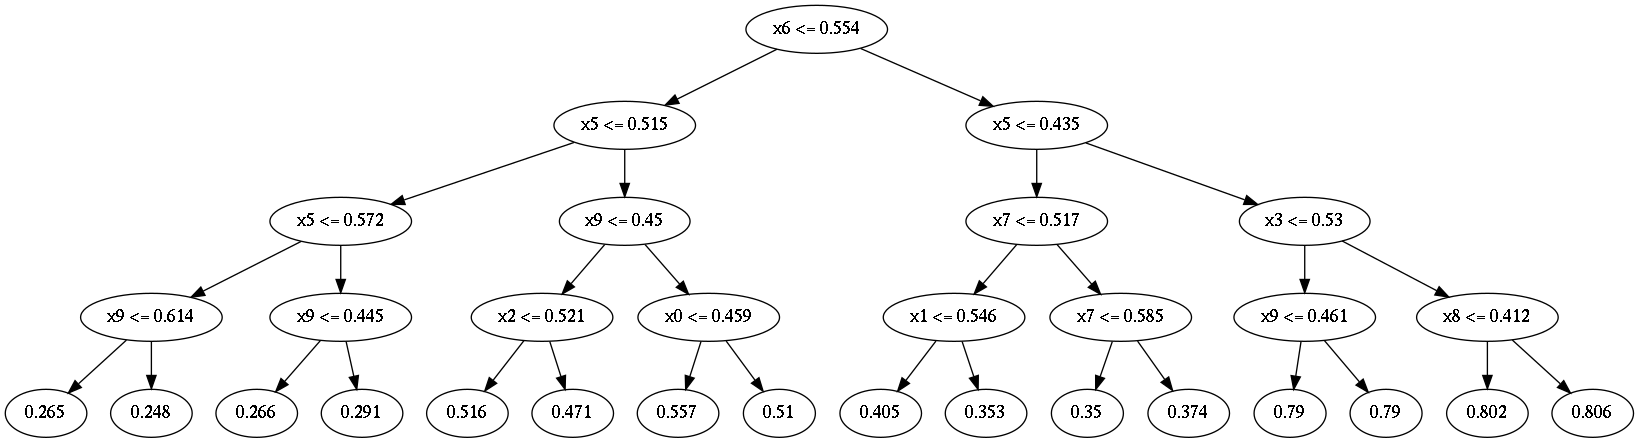

In [22]:
index = 3
dt_parameters = model.predict(np.array([lambda_net_dataset_test.network_parameters_array[index]]))[0]
image, nodes = anytree_decision_tree_from_parameters(dt_parameters, config=config)
image

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 3073)]       0                                            
__________________________________________________________________________________________________
hidden1_512 (Dense)             (None, 512)          1573888     input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 512)          0           hidden1_512[0][0]                
__________________________________________________________________________________________________
dropout1_0.5 (Dropout)          (None, 512)          0           activation1_relu[0][0]           
______________________________________________________________________________________________

In [24]:
if nas:
    for trial in history: 
        print(trial.summary())

In [25]:
y_test_inet_dt_list = []
y_test_distilled_sklearn_dt_list = []

binary_crossentropy_distilled_sklearn_dt_list =[]
accuracy_distilled_sklearn_dt_list = []
f1_score_distilled_sklearn_dt_list = []

binary_crossentropy_inet_dt_list =[]
accuracy_inet_dt_list = []
f1_score_inet_dt_list = []

#inet_metric_function_list = []

number = lambda_net_dataset_test.y_test_lambda_array.shape[0]#10

for lambda_net_parameters, lambda_net, X_test_lambda, y_test_lambda in tqdm(zip(lambda_net_dataset_test.network_parameters_array[:number], lambda_net_dataset_test.network_list[:number], lambda_net_dataset_test.X_test_lambda_array[:number], lambda_net_dataset_test.y_test_lambda_array[:number]), total=lambda_net_dataset_test.y_test_lambda_array[:number].shape[0]):
    dt_inet = model.predict(np.array([lambda_net_parameters]))[0]
    if nas:
        dt_inet = dt_inet[:function_representation_length]

    
    X_data_random = generate_random_data_points_custom(config['data']['x_min'], config['data']['x_max'], config['evaluation']['random_evaluation_dataset_size'], config['data']['number_of_variables'])
    y_data_random_lambda_pred = lambda_net.predict(X_data_random)
    y_data_random_lambda_pred = np.round(y_data_random_lambda_pred).astype(np.int64)
    
    dt_sklearn_distilled = DecisionTreeClassifier(max_depth=config['function_family']['maximum_depth'])
    dt_sklearn_distilled.fit(X_data_random, y_data_random_lambda_pred)
    
    
    if dt_type == 'SDT':
        y_test_inet_dt  = calculate_function_value_from_decision_tree_parameters_wrapper(X_test_lambda, config)(dt_inet).numpy()
    elif dt_type == 'vanilla':
        y_test_inet_dt  = calculate_function_value_from_vanilla_decision_tree_parameters_wrapper(X_test_lambda, config)(dt_inet).numpy()
    y_test_distilled_sklearn_dt = dt_sklearn_distilled.predict(X_test_lambda)
    
    y_test_lambda_pred = lambda_net.predict(X_test_lambda)
    y_test_lambda_pred = np.round(y_test_lambda_pred)
    
    
    #random_model = generate_base_model(config)        
    #random_network_parameters = random_model.get_weights()
    #network_parameters_structure = [network_parameter.shape for network_parameter in random_network_parameters]         
    
    #function_true_placeholder = np.array([0 for i in range(basic_function_representation_length)])
    #function_true_with_network_parameters = np.concatenate([function_true_placeholder, lambda_net_parameters])
    #inet_metric_function = inet_decision_function_fv_metric_wrapper(X_test_lambda, 
    #                                                                 random_model, 
    #                                                                 network_parameters_structure, 
    #                                                                 config, 
    #                                                                 'binary_accuracy')(np.array([function_true_with_network_parameters]), 
    #                                                                                     np.array([dt_inet]))    
    #inet_metric_function_list.append(inet_metric_function)
        
    
    
    binary_crossentropy_distilled_sklearn_dt = log_loss(y_test_lambda_pred, y_test_distilled_sklearn_dt, labels=[0,1])
    accuracy_distilled_sklearn_dt = accuracy_score(y_test_lambda_pred, np.round(y_test_distilled_sklearn_dt))
    f1_score_distilled_sklearn_dt = f1_score(y_test_lambda_pred, np.round(y_test_distilled_sklearn_dt))
    
    binary_crossentropy_inet_dt = log_loss(y_test_lambda_pred, y_test_inet_dt, labels=[0,1])
    accuracy_inet_dt = accuracy_score(y_test_lambda_pred, np.round(y_test_inet_dt))
    f1_score_inet_dt = f1_score(y_test_lambda_pred, np.round(y_test_inet_dt))
    
    
    y_test_inet_dt_list.append(y_test_inet_dt)
    y_test_distilled_sklearn_dt_list.append(y_test_distilled_sklearn_dt)    

    binary_crossentropy_distilled_sklearn_dt_list.append(np.nan_to_num(binary_crossentropy_distilled_sklearn_dt))
    accuracy_distilled_sklearn_dt_list.append(np.nan_to_num(accuracy_distilled_sklearn_dt))
    f1_score_distilled_sklearn_dt_list.append(np.nan_to_num(f1_score_distilled_sklearn_dt))

    binary_crossentropy_inet_dt_list.append(np.nan_to_num(binary_crossentropy_inet_dt))
    accuracy_inet_dt_list.append(np.nan_to_num(accuracy_inet_dt))
    f1_score_inet_dt_list.append(np.nan_to_num(f1_score_inet_dt))
    
y_test_inet_dt_list = np.array(y_test_inet_dt_list)
y_test_distilled_sklearn_dt_list = np.array(y_test_distilled_sklearn_dt_list)

binary_crossentropy_distilled_sklearn_dt_list = np.array(binary_crossentropy_distilled_sklearn_dt_list)
accuracy_distilled_sklearn_dt_list = np.array(accuracy_distilled_sklearn_dt_list)
f1_score_distilled_sklearn_dt_list = np.array(f1_score_distilled_sklearn_dt_list)

binary_crossentropy_inet_dt_list = np.array(binary_crossentropy_inet_dt_list)
accuracy_inet_dt_list = np.array(accuracy_inet_dt_list)
f1_score_inet_dt_list = np.array(f1_score_inet_dt_list)    

    
print('Binary Crossentropy:\t\t', np.round(np.mean(binary_crossentropy_distilled_sklearn_dt_list), 3), '(Sklearn DT)' , '\t', np.round(np.mean(binary_crossentropy_inet_dt_list), 3), '(I-Net DT)')
print('Accuracy:\t\t', np.round(np.mean(accuracy_distilled_sklearn_dt_list), 3), '(Sklearn DT)' , '\t', np.round(np.mean(accuracy_inet_dt_list), 3), '(I-Net DT)')
print('F1 Score:\t\t', np.round(np.mean(f1_score_distilled_sklearn_dt_list), 3), '(Sklearn DT)' , '\t', np.round(np.mean(f1_score_inet_dt_list), 3), '(I-Net DT)')
      

  0%|          | 0/50 [00:00<?, ?it/s]

Binary Crossentropy:		 7.441 (Sklearn DT) 	 0.642 (I-Net DT)
Accuracy:		 0.785 (Sklearn DT) 	 0.618 (I-Net DT)
F1 Score:		 0.762 (Sklearn DT) 	 0.573 (I-Net DT)


# REAL DATA EVALUATION

## ADULT DATASET

In [26]:
feature_names = [
                 "Age", #0
                 "Workclass",  #1
                 "fnlwgt",  #2
                 "Education",  #3
                 "Education-Num",  #4
                 "Marital Status", #5
                 "Occupation",  #6
                 "Relationship",  #7
                 "Race",  #8
                 "Sex",  #9
                 "Capital Gain",  #10
                 "Capital Loss", #11
                 "Hours per week",  #12
                 "Country", #13
                 "capital_gain" #14
                ] 



adult_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', names=feature_names, index_col=False)

drop_features = [
                 #"Age", #0
                 "Workclass",  #1
                 "fnlwgt",  #2
                 "Education",  #3
                 "Education-Num",  #4
                 "Marital Status", #5
                 "Occupation",  #6
                 "Relationship",  #7
                 "Race",  #8
                 #"Sex",  #9 
                 #"Capital Gain",  #10
                 #"Capital Loss", #11
                 "Hours per week",  #12
                 "Country", #13
                ]

#dataframe = dataframe.drop(drop_features , axis=1)
adult_data = adult_data.drop(['Country'] , axis=1)

categorical_features = [
                        1, #"Workclass"
                        3, #"Education"
                        5, #"Marital Status"
                        6, #"Occupation"
                        7, #"Relationship"
                        8, #"Race"
                        9, #"Sex"
                        #13, #"Country
                       ] 



In [27]:
adult_data

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,capital_gain
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,<=50K


In [28]:
adult_data.describe()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week
count,32561.000,32561.000,32561.000,32561.000,32561.000,32561.000
mean,38.582,189778.367,10.081,1077.649,87.304,40.437
std,13.640,105549.978,2.573,7385.292,402.960,12.347
min,17.000,12285.000,1.000,0.000,0.000,1.000
25%,28.000,117827.000,9.000,0.000,0.000,40.000
50%,37.000,178356.000,10.000,0.000,0.000,40.000
75%,48.000,237051.000,12.000,0.000,0.000,45.000
max,90.000,1484705.000,16.000,99999.000,4356.000,99.000


In [29]:
adult_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education-Num   32561 non-null  int64 
 5   Marital Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital Gain    32561 non-null  int64 
 11  Capital Loss    32561 non-null  int64 
 12  Hours per week  32561 non-null  int64 
 13  capital_gain    32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


In [30]:
adult_data['capital_gain'].value_counts()


 <=50K    24720
 >50K      7841
Name: capital_gain, dtype: int64

In [31]:
adult_data.shape

(32561, 14)

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder

In [33]:
y_data_adult = adult_data['capital_gain']
le = LabelEncoder()
le.fit(y_data_adult)
y_data_adult = le.transform(y_data_adult)
class_names = le.classes_

X_data_adult = adult_data.drop('capital_gain', axis=1)

In [34]:
print(X_data_adult.shape)

(32561, 13)


In [35]:
X_data_adult[:5]

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40


In [36]:
transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categorical_features)], remainder='passthrough', sparse_threshold=0)
transformer.fit(X_data_adult)

X_data_adult = transformer.transform(X_data_adult)
X_data_adult = X_data_adult.astype(np.float64)
X_data_adult = pd.DataFrame(X_data_adult.astype(np.float64), columns=transformer.get_feature_names())
X_data_adult.head()

,cat__x0_ ?,cat__x0_ Federal-gov,cat__x0_ Local-gov,cat__x0_ Never-worked,cat__x0_ Private,cat__x0_ Self-emp-inc,cat__x0_ Self-emp-not-inc,cat__x0_ State-gov,cat__x0_ Without-pay,cat__x1_ 10th,cat__x1_ 11th,cat__x1_ 12th,cat__x1_ 1st-4th,cat__x1_ 5th-6th,cat__x1_ 7th-8th,cat__x1_ 9th,cat__x1_ Assoc-acdm,cat__x1_ Assoc-voc,cat__x1_ Bachelors,cat__x1_ Doctorate,cat__x1_ HS-grad,cat__x1_ Masters,cat__x1_ Preschool,cat__x1_ Prof-school,cat__x1_ Some-college,cat__x2_ Divorced,cat__x2_ Married-AF-spouse,cat__x2_ Married-civ-spouse,cat__x2_ Married-spouse-absent,cat__x2_ Never-married,cat__x2_ Separated,cat__x2_ Widowed,cat__x3_ ?,cat__x3_ Adm-clerical,cat__x3_ Armed-Forces,cat__x3_ Craft-repair,cat__x3_ Exec-managerial,cat__x3_ Farming-fishing,cat__x3_ Handlers-cleaners,cat__x3_ Machine-op-inspct,cat__x3_ Other-service,cat__x3_ Priv-house-serv,cat__x3_ Prof-specialty,cat__x3_ Protective-serv,cat__x3_ Sales,cat__x3_ Tech-support,cat__x3_ Transport-moving,cat__x4_ Husband,cat__x4_ Not-in-family,cat__x4_ Other-relative,cat__x4_ Own-child,cat__x4_ Unmarried,cat__x4_ Wife,cat__x5_ Amer-Indian-Eskimo,cat__x5_ Asian-Pac-Islander,cat__x5_ Black,cat__x5_ Other,cat__x5_ White,cat__x6_ Female,cat__x6_ Male,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,39.000,77516.000,13.000,2174.000,0.000,40.000
1,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,50.000,83311.000,13.000,0.000,0.000,13.000
2,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,38.000,215646.000,9.000,0.000,0.000,40.000
3,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,53.000,234721.000,7.000,0.000,0.000,40.000
4,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,28.000,338409.000,13.000,0.000,0.000,40.000


In [37]:
X_data_adult = X_data_adult.sample(n=number_of_variables,axis='columns')
X_data_adult.head()

,cat__x0_ Private,cat__x3_ Priv-house-serv,cat__x6_ Male,cat__x4_ Not-in-family,cat__x2_ Divorced,cat__x1_ 10th,cat__x0_ Never-worked,cat__x2_ Married-AF-spouse,Capital Loss,cat__x1_ Prof-school
0,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,1.000,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000
3,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [38]:
normalizer_list = []
for column_name in X_data_adult:
    scaler = MinMaxScaler()
    scaler.fit(X_data_adult[column_name].values.reshape(-1, 1))
    X_data_adult[column_name] = scaler.transform(X_data_adult[column_name].values.reshape(-1, 1)).ravel()
    normalizer_list.append(scaler)
X_data_adult.head()

,cat__x0_ Private,cat__x3_ Priv-house-serv,cat__x6_ Male,cat__x4_ Not-in-family,cat__x2_ Divorced,cat__x1_ 10th,cat__x0_ Never-worked,cat__x2_ Married-AF-spouse,Capital Loss,cat__x1_ Prof-school
0,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,1.000,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000
3,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [39]:
print(X_data_adult.shape)

(32561, 10)


In [40]:
X_train_adult_with_valid, X_test_adult, y_train_adult_with_valid, y_test_adult = train_test_split(X_data_adult, y_data_adult, train_size=0.8)
X_train_adult, X_valid_adult, y_train_adult, y_valid_adult = train_test_split(X_train_adult_with_valid, y_train_adult_with_valid, train_size=0.8)


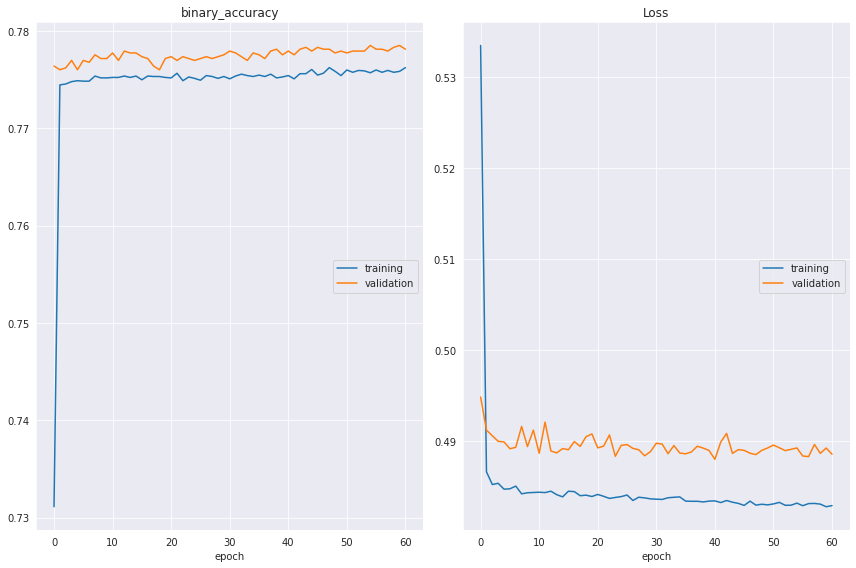

binary_accuracy
	training         	 (min:    0.731, max:    0.776, cur:    0.776)
	validation       	 (min:    0.776, max:    0.779, cur:    0.778)
Loss
	training         	 (min:    0.483, max:    0.533, cur:    0.483)
	validation       	 (min:    0.488, max:    0.495, cur:    0.489)


In [41]:
test_network = generate_lambda_net_from_config(config)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=50, 
                                                  min_delta=0.001, 
                                                  verbose=0, 
                                                  mode='min', 
                                                  restore_best_weights=True)

model_history = test_network.fit(X_train_adult,
                                  y_train_adult, 
                                  epochs=config['lambda_net']['epochs_lambda'], 
                                  batch_size=config['lambda_net']['batch_lambda'], 
                                  callbacks=[early_stopping, PlotLossesKerasTF()],
                                  validation_data=(X_valid_adult, y_valid_adult),
                                  verbose=0)



In [42]:
test_network.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               2816      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________


In [43]:
test_network_parameters = shaped_network_parameters_to_array(test_network.get_weights(), config)
test_network_dt_inet = model.predict(np.array([test_network_parameters]))[0]

if nas:
    test_network_dt_inet = test_network_dt_inet[:function_representation_length]

X_data_random = generate_random_data_points_custom(config['data']['x_min'], config['data']['x_max'], config['evaluation']['random_evaluation_dataset_size'], config['data']['number_of_variables'])
y_data_random_test_network_pred = test_network.predict(X_data_random)
y_data_random_test_network_pred = np.round(y_data_random_test_network_pred).astype(np.int64)

dt_sklearn_distilled = DecisionTreeClassifier(max_depth=config['function_family']['maximum_depth'])
dt_sklearn_distilled.fit(X_data_random, y_data_random_test_network_pred)


if dt_type == 'SDT':
    y_test_inet_dt  = calculate_function_value_from_decision_tree_parameters_wrapper(X_test_adult, config)(test_network_dt_inet).numpy()
elif dt_type == 'vanilla':
    y_test_inet_dt  = calculate_function_value_from_vanilla_decision_tree_parameters_wrapper(X_test_adult, config)(test_network_dt_inet).numpy()
y_test_distilled_sklearn_dt = dt_sklearn_distilled.predict(X_test_adult)

y_test_test_network_pred = test_network.predict(X_test_adult)
y_test_test_network_pred = np.round(y_test_test_network_pred)

binary_crossentropy_distilled_sklearn_dt = log_loss(y_test_test_network_pred, y_test_distilled_sklearn_dt, labels=[0,1])
accuracy_distilled_sklearn_dt = accuracy_score(y_test_test_network_pred, np.round(y_test_distilled_sklearn_dt))
f1_score_distilled_sklearn_dt = f1_score(y_test_test_network_pred, np.round(y_test_distilled_sklearn_dt))

binary_crossentropy_inet_dt = log_loss(y_test_test_network_pred, y_test_inet_dt, labels=[0,1])
accuracy_inet_dt = accuracy_score(y_test_test_network_pred, np.round(y_test_inet_dt))
f1_score_inet_dt = f1_score(y_test_test_network_pred, np.round(y_test_inet_dt))


print('Binary Crossentropy:\t\t', np.round(binary_crossentropy_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(binary_crossentropy_inet_dt, 3), '(I-Net DT)')
print('Accuracy:\t\t', np.round(accuracy_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(accuracy_inet_dt, 3), '(I-Net DT)')
print('F1 Score:\t\t', np.round(f1_score_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(f1_score_inet_dt, 3), '(I-Net DT)')
     


Binary Crossentropy:		 33.256 (Sklearn DT) 	 0.505 (I-Net DT)
Accuracy:		 0.037 (Sklearn DT) 	 0.969 (I-Net DT)
F1 Score:		 0.059 (Sklearn DT) 	 0.456 (I-Net DT)


In [44]:
splits, leaf_classes = get_shaped_parameters_for_decision_tree(test_network_dt_inet, config)
print(splits, leaf_classes)

tf.Tensor(
[[0.         0.         0.         0.         0.         0.
  0.565165   0.         0.         0.        ]
 [0.         0.         0.         0.43357044 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.5083325  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.5348896  0.         0.
  0.         0.         0.         0.        ]
 [0.         0.5204693  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.49276546 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.53295344]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.46307433]
 [0.         0.         0.5871348  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.37656236 0.

In [45]:
#%load_ext autoreload

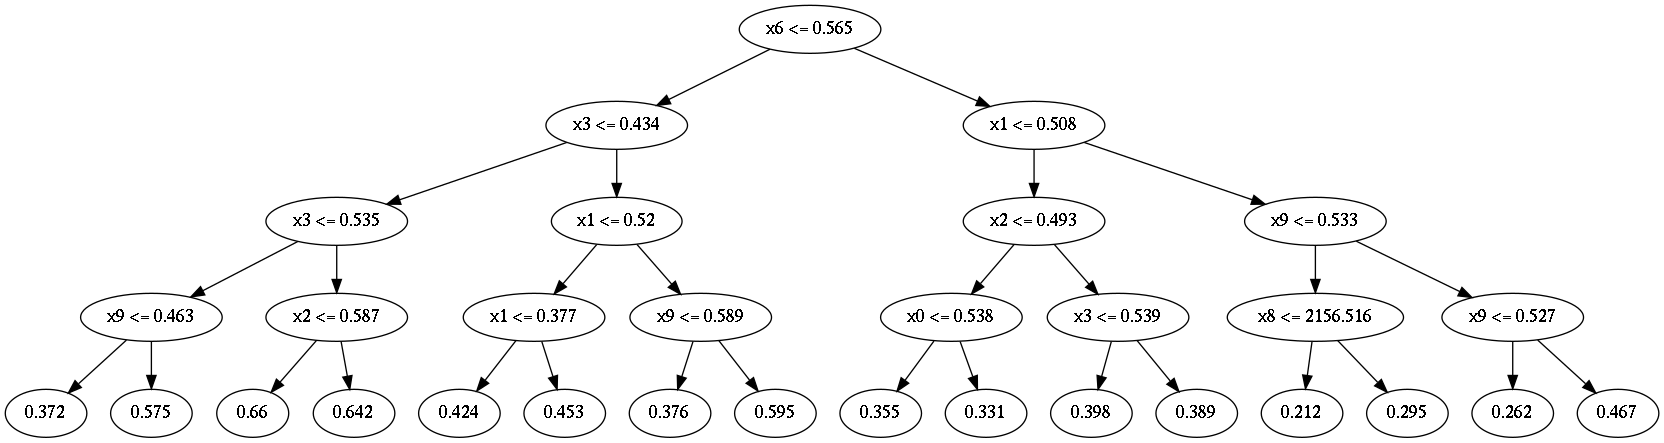

In [46]:
#%autoreload 2
image, nodes = anytree_decision_tree_from_parameters(test_network_dt_inet, config=config, normalizer_list=normalizer_list)
image
#tree.show()

In [47]:
#tree = treelib_decision_tree_from_parameters(test_network_dt_inet, config=config, normalizer_list=normalizer_list)
#tree = treelib_decision_tree_from_parameters(test_network_dt_inet, config=config)

#tree.show()

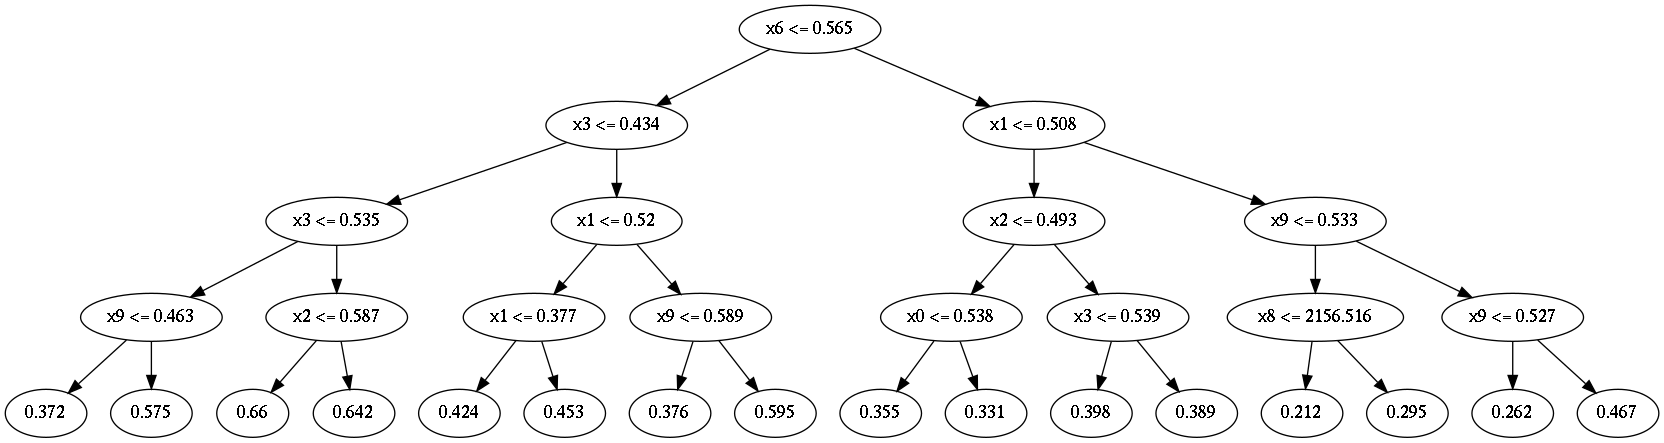

In [48]:
#%autoreload 2
image, nodes = anytree_decision_tree_from_parameters(test_network_dt_inet, config=config, normalizer_list=normalizer_list)
image
#tree.show()

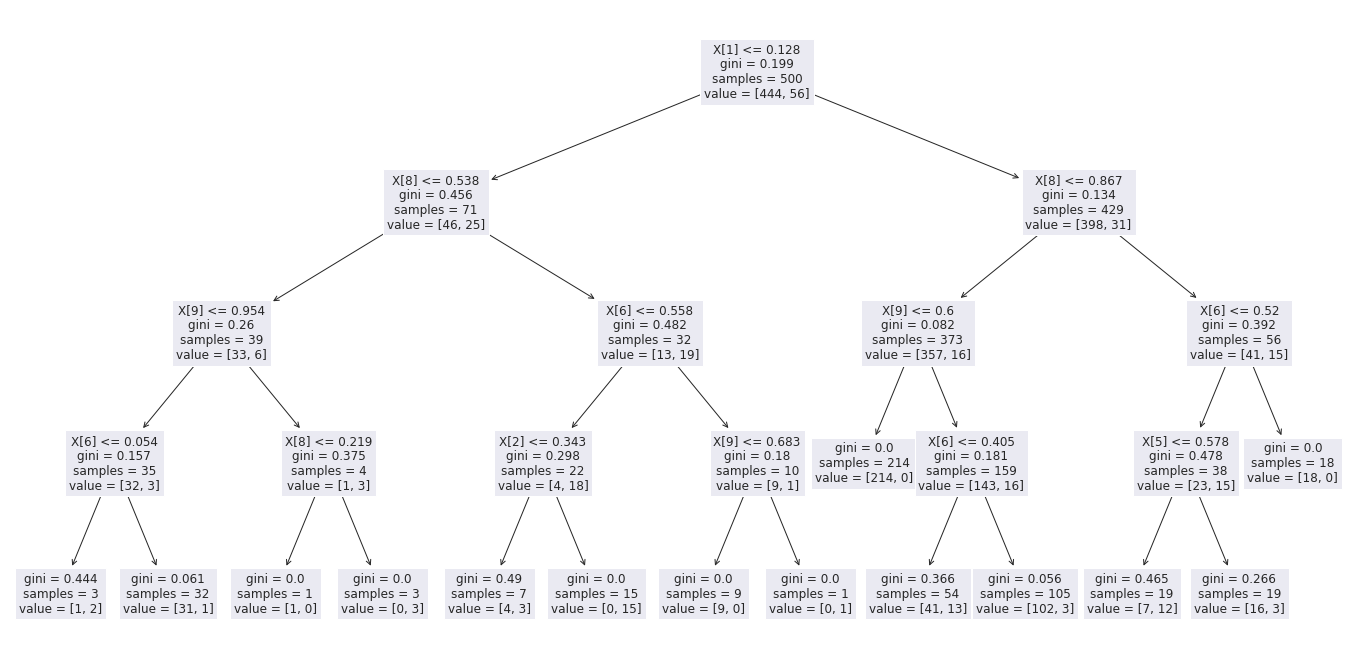

In [49]:
plt.figure(figsize=(24,12))  # set plot size (denoted in inches)
plot_tree(dt_sklearn_distilled, fontsize=12)
plt.show()

## COVID-19 Symptoms Dataset (Binary Classification for Severe Disease)

In [50]:
feature_names = []

covid_data = pd.read_csv("./real_world_datasets/COVID-19-Symptoms/Cleaned-Data.csv")

covid_data.head()

,Fever,Tiredness,Dry-Cough,Difficulty-in-Breathing,Sore-Throat,None_Sympton,Pains,Nasal-Congestion,Runny-Nose,Diarrhea,None_Experiencing,Age_0-9,Age_10-19,Age_20-24,Age_25-59,Age_60+,Gender_Female,Gender_Male,Gender_Transgender,Severity_Mild,Severity_Moderate,Severity_None,Severity_Severe,Contact_Dont-Know,Contact_No,Contact_Yes,Country
0,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,China
1,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,China
2,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,China
3,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,China
4,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,China


In [51]:
covid_data.describe()

,Fever,Tiredness,Dry-Cough,Difficulty-in-Breathing,Sore-Throat,None_Sympton,Pains,Nasal-Congestion,Runny-Nose,Diarrhea,None_Experiencing,Age_0-9,Age_10-19,Age_20-24,Age_25-59,Age_60+,Gender_Female,Gender_Male,Gender_Transgender,Severity_Mild,Severity_Moderate,Severity_None,Severity_Severe,Contact_Dont-Know,Contact_No,Contact_Yes
count,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000
mean,0.312,0.500,0.562,0.500,0.312,0.062,0.364,0.545,0.545,0.364,0.091,0.200,0.200,0.200,0.200,0.200,0.333,0.333,0.333,0.250,0.250,0.250,0.250,0.333,0.333,0.333
std,0.464,0.500,0.496,0.500,0.464,0.242,0.481,0.498,0.498,0.481,0.287,0.400,0.400,0.400,0.400,0.400,0.471,0.471,0.471,0.433,0.433,0.433,0.433,0.471,0.471,0.471
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,0.500,1.000,0.500,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,1.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.250,0.250,0.250,0.250,1.000,1.000,1.000
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [52]:
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Fever                    316800 non-null  int64 
 1   Tiredness                316800 non-null  int64 
 2   Dry-Cough                316800 non-null  int64 
 3   Difficulty-in-Breathing  316800 non-null  int64 
 4   Sore-Throat              316800 non-null  int64 
 5   None_Sympton             316800 non-null  int64 
 6   Pains                    316800 non-null  int64 
 7   Nasal-Congestion         316800 non-null  int64 
 8   Runny-Nose               316800 non-null  int64 
 9   Diarrhea                 316800 non-null  int64 
 10  None_Experiencing        316800 non-null  int64 
 11  Age_0-9                  316800 non-null  int64 
 12  Age_10-19                316800 non-null  int64 
 13  Age_20-24                316800 non-null  int64 
 14  Age_25-59           

In [53]:
covid_data = covid_data.drop(['Country'], axis=1)

In [54]:
covid_data.head()

,Fever,Tiredness,Dry-Cough,Difficulty-in-Breathing,Sore-Throat,None_Sympton,Pains,Nasal-Congestion,Runny-Nose,Diarrhea,None_Experiencing,Age_0-9,Age_10-19,Age_20-24,Age_25-59,Age_60+,Gender_Female,Gender_Male,Gender_Transgender,Severity_Mild,Severity_Moderate,Severity_None,Severity_Severe,Contact_Dont-Know,Contact_No,Contact_Yes
0,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
1,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0
2,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0
3,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1
4,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0


In [55]:
def severity_binary(row):
    if row['Severity_Severe'] == 1:
        val = 1
    else:
        val = 0
    return val

In [56]:
covid_data['severe'] = covid_data.apply(severity_binary, axis=1)
covid_data = covid_data.drop(['Severity_None', 'Severity_Mild', 'Severity_Moderate', 'Severity_Severe'], axis=1)

In [57]:
covid_data.head()

,Fever,Tiredness,Dry-Cough,Difficulty-in-Breathing,Sore-Throat,None_Sympton,Pains,Nasal-Congestion,Runny-Nose,Diarrhea,None_Experiencing,Age_0-9,Age_10-19,Age_20-24,Age_25-59,Age_60+,Gender_Female,Gender_Male,Gender_Transgender,Contact_Dont-Know,Contact_No,Contact_Yes,severe
0,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0
1,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0
2,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0
3,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0
4,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0


In [58]:
covid_data.describe()

,Fever,Tiredness,Dry-Cough,Difficulty-in-Breathing,Sore-Throat,None_Sympton,Pains,Nasal-Congestion,Runny-Nose,Diarrhea,None_Experiencing,Age_0-9,Age_10-19,Age_20-24,Age_25-59,Age_60+,Gender_Female,Gender_Male,Gender_Transgender,Contact_Dont-Know,Contact_No,Contact_Yes,severe
count,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000,316800.000
mean,0.312,0.500,0.562,0.500,0.312,0.062,0.364,0.545,0.545,0.364,0.091,0.200,0.200,0.200,0.200,0.200,0.333,0.333,0.333,0.333,0.333,0.333,0.250
std,0.464,0.500,0.496,0.500,0.464,0.242,0.481,0.498,0.498,0.481,0.287,0.400,0.400,0.400,0.400,0.400,0.471,0.471,0.471,0.471,0.471,0.471,0.433
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,0.500,1.000,0.500,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,1.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,0.250
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [59]:
covid_data['severe'].value_counts()


0    237600
1     79200
Name: severe, dtype: int64

In [60]:
features_select = [
                    'Fever',
                    #'Tiredness',
                    #'Dry-Cough',
                    'Difficulty-in-Breathing',    
                    #'Sore-Throat',
                    'None_Sympton',    
                    #'Pains',
                    #'Nasal-Congestion',    
                    #'Runny-Nose',
                    'Diarrhea',    
                    'None_Experiencing',
                    #'Age_0-9',    
                    #'Age_10-19',    
                    #'Age_20-24',    
                    #'Age_25-59',    
                    #'Age_60+',    
                    #'Gender_Female',    
                    #'Gender_Male',    
                    #'Gender_Transgender',    
                    #'Contact_Dont-Know',    
                    #'Contact_No',    
                    #'Contact_Yes',    
                    'severe' #TARGET
                  ]

covid_data_reduced = covid_data#[features_select]

X_data_covid = covid_data_reduced.drop(['severe'], axis=1)#.values
y_data_covid = covid_data_reduced['severe']#.values

if X_data_covid.shape[1] > number_of_variables:
    X_data_covid = X_data_covid.sample(n=number_of_variables,axis='columns')
else:
    for i in range(number_of_variables-X_data_covid.shape[1]):
        column_name = 'zero_dummy_' + str(i+1)
        X_data_covid[column_name] = np.zeros(X_data_covid.shape[0])
X_data_covid.head()

,Gender_Male,Pains,Difficulty-in-Breathing,Tiredness,Contact_No,Fever,None_Experiencing,None_Sympton,Sore-Throat,Age_60+
0,1,1,1,1,0,1,0,0,1,0
1,1,1,1,1,1,1,0,0,1,0
2,1,1,1,1,0,1,0,0,1,0
3,1,1,1,1,0,1,0,0,1,0
4,1,1,1,1,1,1,0,0,1,0


In [61]:
X_train_covid_with_valid, X_test_covid, y_train_covid_with_valid, y_test_covid = train_test_split(X_data_covid, y_data_covid, train_size=0.8)
X_train_covid, X_valid_covid, y_train_covid, y_valid_covid = train_test_split(X_train_covid_with_valid, y_train_covid_with_valid, train_size=0.8)

print(X_train_covid.shape, y_train_covid.shape)
print(X_valid_covid.shape, y_valid_covid.shape)
print(X_test_covid.shape, y_test_covid.shape)

(202752, 10) (202752,)
(50688, 10) (50688,)
(63360, 10) (63360,)


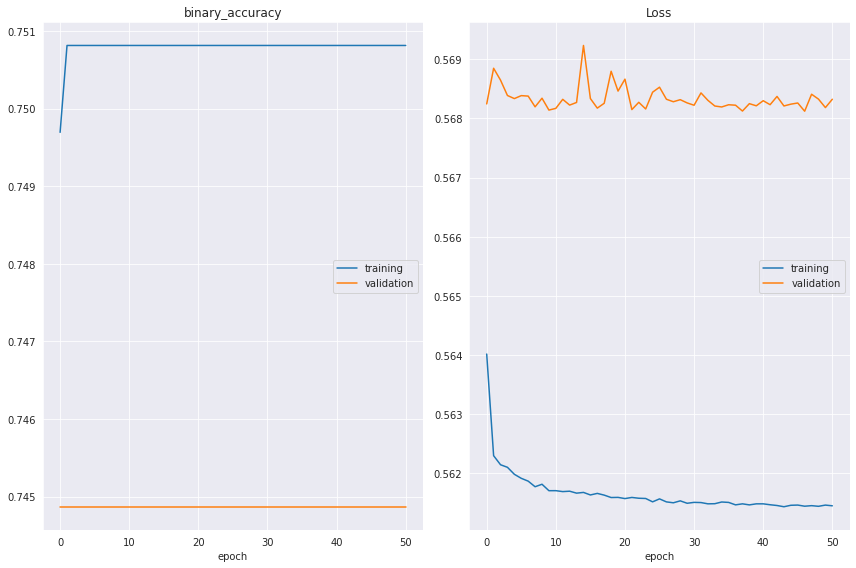

binary_accuracy
	training         	 (min:    0.750, max:    0.751, cur:    0.751)
	validation       	 (min:    0.745, max:    0.745, cur:    0.745)
Loss
	training         	 (min:    0.561, max:    0.564, cur:    0.561)
	validation       	 (min:    0.568, max:    0.569, cur:    0.568)


In [62]:
test_network = generate_lambda_net_from_config(config)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=50, 
                                                  min_delta=0.001, 
                                                  verbose=0, 
                                                  mode='min', 
                                                  restore_best_weights=True)

model_history = test_network.fit(X_train_covid,
                                  y_train_covid, 
                                  epochs=config['lambda_net']['epochs_lambda'], 
                                  batch_size=config['lambda_net']['batch_lambda'], 
                                  callbacks=[early_stopping, PlotLossesKerasTF()],
                                  validation_data=(X_valid_covid, y_valid_covid),
                                  verbose=0)



In [63]:
test_network_parameters = shaped_network_parameters_to_array(test_network.get_weights(), config)
test_network_dt_inet = model.predict(np.array([test_network_parameters]))[0]

if nas:
    test_network_dt_inet = test_network_dt_inet[:function_representation_length]

X_data_random = generate_random_data_points_custom(config['data']['x_min'], config['data']['x_max'], config['evaluation']['random_evaluation_dataset_size'], config['data']['number_of_variables'])
y_data_random_test_network_pred = test_network.predict(X_data_random)
y_data_random_test_network_pred = np.round(y_data_random_test_network_pred).astype(np.int64)

dt_sklearn_distilled = DecisionTreeClassifier(max_depth=config['function_family']['maximum_depth'])
dt_sklearn_distilled.fit(X_data_random, y_data_random_test_network_pred)


if dt_type == 'SDT':
    y_test_inet_dt  = calculate_function_value_from_decision_tree_parameters_wrapper(X_test_covid, config)(test_network_dt_inet).numpy()
elif dt_type == 'vanilla':
    y_test_inet_dt  = calculate_function_value_from_vanilla_decision_tree_parameters_wrapper(X_test_covid, config)(test_network_dt_inet).numpy()
y_test_distilled_sklearn_dt = dt_sklearn_distilled.predict(X_test_covid)

y_test_test_network_pred = test_network.predict(X_test_covid)
y_test_test_network_pred = np.round(y_test_test_network_pred)

binary_crossentropy_distilled_sklearn_dt = log_loss(y_test_test_network_pred, y_test_distilled_sklearn_dt, labels=[0,1])
accuracy_distilled_sklearn_dt = accuracy_score(y_test_test_network_pred, np.round(y_test_distilled_sklearn_dt))
f1_score_distilled_sklearn_dt = f1_score(y_test_test_network_pred, np.round(y_test_distilled_sklearn_dt))

binary_crossentropy_inet_dt = log_loss(y_test_test_network_pred, y_test_inet_dt, labels=[0,1])
accuracy_inet_dt = accuracy_score(y_test_test_network_pred, np.round(y_test_inet_dt))
f1_score_inet_dt = f1_score(y_test_test_network_pred, np.round(y_test_inet_dt))


print('Binary Crossentropy:\t\t', np.round(binary_crossentropy_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(binary_crossentropy_inet_dt, 3), '(I-Net DT)')
print('Accuracy:\t\t', np.round(accuracy_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(accuracy_inet_dt, 3), '(I-Net DT)')
print('F1 Score:\t\t', np.round(f1_score_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(f1_score_inet_dt, 3), '(I-Net DT)')
     


Binary Crossentropy:		 0.0 (Sklearn DT) 	 0.497 (I-Net DT)
Accuracy:		 1.0 (Sklearn DT) 	 1.0 (I-Net DT)
F1 Score:		 0.0 (Sklearn DT) 	 0.0 (I-Net DT)


In [64]:
#%autoreload 2
image, nodes = anytree_decision_tree_from_parameters(test_network_dt_inet, config=config, normalizer_list=normalizer_list)
image
#tree.show()

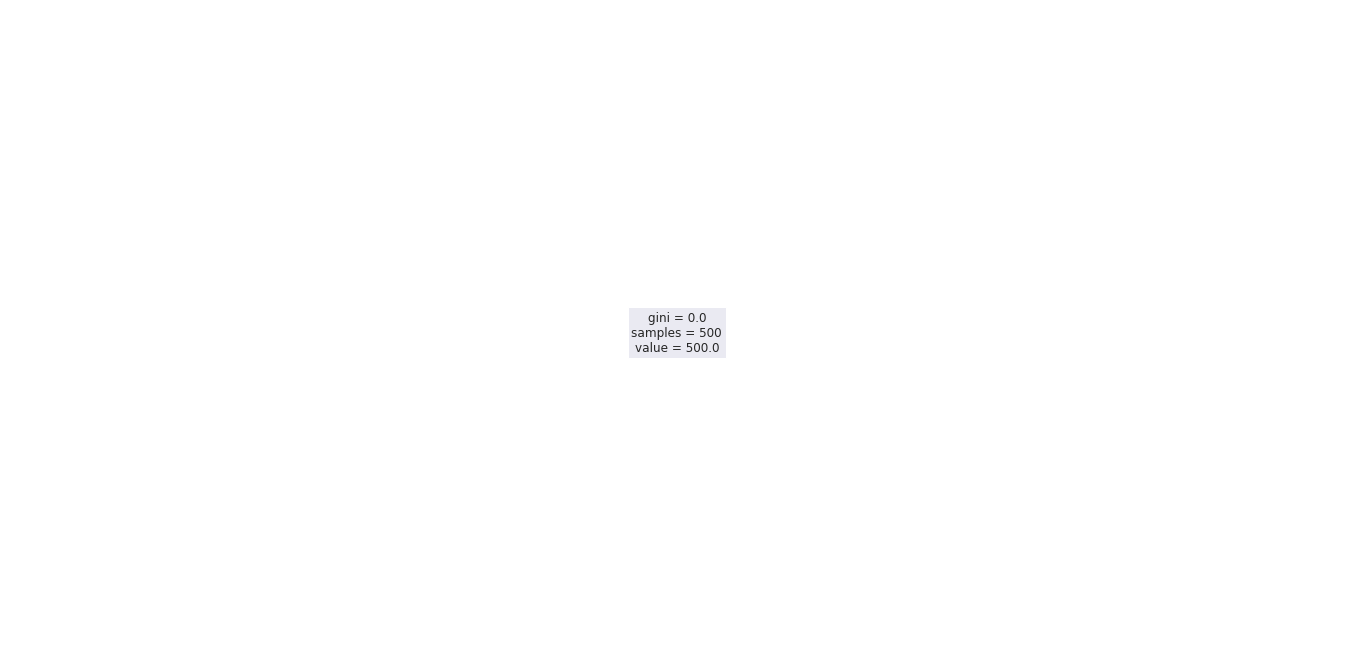

In [65]:
plt.figure(figsize=(24,12))  # set plot size (denoted in inches)
plot_tree(dt_sklearn_distilled, fontsize=12)
plt.show()

## Titanic Dataset

In [66]:
titanic_data = pd.read_csv("./real_world_datasets/Titanic/train.csv")

titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [67]:
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000,891.000,891.000,714.000,891.000,891.000,891.000
mean,446.000,0.384,2.309,29.699,0.523,0.382,32.204
std,257.354,0.487,0.836,14.526,1.103,0.806,49.693
min,1.000,0.000,1.000,0.420,0.000,0.000,0.000
25%,223.500,0.000,2.000,20.125,0.000,0.000,7.910
50%,446.000,0.000,3.000,28.000,0.000,0.000,14.454
75%,668.500,1.000,3.000,38.000,1.000,0.000,31.000
max,891.000,1.000,3.000,80.000,8.000,6.000,512.329


In [68]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [69]:
titanic_data = titanic_data.drop(['Cabin', 'Ticket', 'Name', 'PassengerId'], axis = 1)


In [70]:
titanic_data.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [71]:
titanic_data['Age'].fillna(titanic_data['Age'].mean(), inplace = True)
#titanic_data['Fare'].fillna(titanic_data['Fare'].mean(), inplace = True)
    
titanic_data['Embarked'].fillna('S', inplace = True)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.000,1,0,7.250,S
1,1,1,female,38.000,1,0,71.283,C
2,1,3,female,26.000,0,0,7.925,S
3,1,1,female,35.000,1,0,53.100,S
4,0,3,male,35.000,0,0,8.050,S


In [72]:
features_select = [
                    'Pclass',
                    'Sex',    
                    'Age',
                    'SibSp',    
                    'Parch',
                    'Fare',    
                    'Embarked',
                    'Survived'
                  ]

titanic_data = titanic_data[features_select]

categorical_features = [1, 6]


transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categorical_features)], remainder='passthrough', sparse_threshold=0)
transformer.fit(titanic_data)

titanic_data = transformer.transform(titanic_data)
titanic_data = titanic_data.astype(np.float64)
titanic_data = pd.DataFrame(titanic_data.astype(np.float64), columns=transformer.get_feature_names())

X_data_titanic = titanic_data.drop(['Survived'], axis = 1)
y_data_titanic = titanic_data['Survived']
X_data_titanic.head()

,cat__x0_female,cat__x0_male,cat__x1_C,cat__x1_Q,cat__x1_S,Pclass,Age,SibSp,Parch,Fare
0,0.000,1.000,0.000,0.000,1.000,3.000,22.000,1.000,0.000,7.250
1,1.000,0.000,1.000,0.000,0.000,1.000,38.000,1.000,0.000,71.283
2,1.000,0.000,0.000,0.000,1.000,3.000,26.000,0.000,0.000,7.925
3,1.000,0.000,0.000,0.000,1.000,1.000,35.000,1.000,0.000,53.100
4,0.000,1.000,0.000,0.000,1.000,3.000,35.000,0.000,0.000,8.050


In [73]:
if X_data_titanic.shape[1] > number_of_variables:
    X_data_titanic = X_data_titanic.sample(n=number_of_variables,axis='columns')
else:
    for i in range(number_of_variables-X_data_titanic.shape[1]):
        column_name = 'zero_dummy_' + str(i+1)
        X_data_titanic[column_name] = np.zeros(X_data_titanic.shape[0])
X_data_titanic.head()

,cat__x0_female,cat__x0_male,cat__x1_C,cat__x1_Q,cat__x1_S,Pclass,Age,SibSp,Parch,Fare
0,0.000,1.000,0.000,0.000,1.000,3.000,22.000,1.000,0.000,7.250
1,1.000,0.000,1.000,0.000,0.000,1.000,38.000,1.000,0.000,71.283
2,1.000,0.000,0.000,0.000,1.000,3.000,26.000,0.000,0.000,7.925
3,1.000,0.000,0.000,0.000,1.000,1.000,35.000,1.000,0.000,53.100
4,0.000,1.000,0.000,0.000,1.000,3.000,35.000,0.000,0.000,8.050


In [74]:
normalizer_list = []
for column_name in X_data_titanic:
    scaler = MinMaxScaler()
    scaler.fit(X_data_titanic[column_name].values.reshape(-1, 1))
    X_data_titanic[column_name] = scaler.transform(X_data_titanic[column_name].values.reshape(-1, 1)).ravel()
    normalizer_list.append(scaler)
X_data_titanic.head()

,cat__x0_female,cat__x0_male,cat__x1_C,cat__x1_Q,cat__x1_S,Pclass,Age,SibSp,Parch,Fare
0,0.000,1.000,0.000,0.000,1.000,1.000,0.271,0.125,0.000,0.014
1,1.000,0.000,1.000,0.000,0.000,0.000,0.472,0.125,0.000,0.139
2,1.000,0.000,0.000,0.000,1.000,1.000,0.321,0.000,0.000,0.015
3,1.000,0.000,0.000,0.000,1.000,0.000,0.435,0.125,0.000,0.104
4,0.000,1.000,0.000,0.000,1.000,1.000,0.435,0.000,0.000,0.016


In [75]:
y_data_titanic

0     0.000
1     1.000
2     1.000
3     1.000
4     0.000
       ... 
886   0.000
887   1.000
888   0.000
889   1.000
890   0.000
Name: Survived, Length: 891, dtype: float64

In [76]:
X_train_titanic_with_valid, X_test_titanic, y_train_titanic_with_valid, y_test_titanic = train_test_split(X_data_titanic, y_data_titanic, train_size=0.8)
X_train_titanic, X_valid_titanic, y_train_titanic, y_valid_titanic = train_test_split(X_train_titanic_with_valid, y_train_titanic_with_valid, train_size=0.8)

print(X_train_titanic.shape, y_train_titanic.shape)
print(X_valid_titanic.shape, y_valid_titanic.shape)
print(X_test_titanic.shape, y_test_titanic.shape)

(569, 10) (569,)
(143, 10) (143,)
(179, 10) (179,)


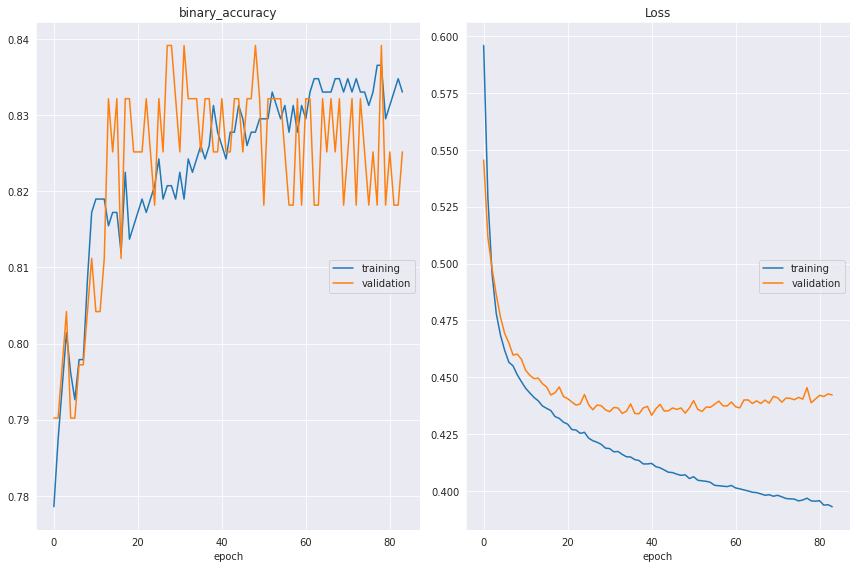

binary_accuracy
	training         	 (min:    0.779, max:    0.837, cur:    0.833)
	validation       	 (min:    0.790, max:    0.839, cur:    0.825)
Loss
	training         	 (min:    0.393, max:    0.596, cur:    0.393)
	validation       	 (min:    0.433, max:    0.545, cur:    0.442)


In [77]:
test_network = generate_lambda_net_from_config(config)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=50, 
                                                  min_delta=0.001, 
                                                  verbose=0, 
                                                  mode='min', 
                                                  restore_best_weights=True)

model_history = test_network.fit(X_train_titanic,
                                  y_train_titanic, 
                                  epochs=config['lambda_net']['epochs_lambda'], 
                                  batch_size=config['lambda_net']['batch_lambda'], 
                                  callbacks=[early_stopping, PlotLossesKerasTF()],
                                  validation_data=(X_valid_titanic, y_valid_titanic),
                                  verbose=0)



In [78]:
test_network_parameters = shaped_network_parameters_to_array(test_network.get_weights(), config)
test_network_dt_inet = model.predict(np.array([test_network_parameters]))[0]

if nas:
    test_network_dt_inet = test_network_dt_inet[:function_representation_length]

X_data_random = generate_random_data_points_custom(config['data']['x_min'], config['data']['x_max'], config['evaluation']['random_evaluation_dataset_size'], config['data']['number_of_variables'])
y_data_random_test_network_pred = test_network.predict(X_data_random)
y_data_random_test_network_pred = np.round(y_data_random_test_network_pred).astype(np.int64)

dt_sklearn_distilled = DecisionTreeClassifier(max_depth=config['function_family']['maximum_depth'])
dt_sklearn_distilled.fit(X_data_random, y_data_random_test_network_pred)


if dt_type == 'SDT':
    y_test_inet_dt  = calculate_function_value_from_decision_tree_parameters_wrapper(X_test_titanic, config)(test_network_dt_inet).numpy()
elif dt_type == 'vanilla':
    y_test_inet_dt  = calculate_function_value_from_vanilla_decision_tree_parameters_wrapper(X_test_titanic, config)(test_network_dt_inet).numpy()
y_test_distilled_sklearn_dt = dt_sklearn_distilled.predict(X_test_titanic)

y_test_test_network_pred = test_network.predict(X_test_titanic)
y_test_test_network_pred = np.round(y_test_test_network_pred)

binary_crossentropy_distilled_sklearn_dt = log_loss(y_test_test_network_pred, y_test_distilled_sklearn_dt, labels=[0,1])
accuracy_distilled_sklearn_dt = accuracy_score(y_test_test_network_pred, np.round(y_test_distilled_sklearn_dt))
f1_score_distilled_sklearn_dt = f1_score(y_test_test_network_pred, np.round(y_test_distilled_sklearn_dt))

binary_crossentropy_inet_dt = log_loss(y_test_test_network_pred, y_test_inet_dt, labels=[0,1])
accuracy_inet_dt = accuracy_score(y_test_test_network_pred, np.round(y_test_inet_dt))
f1_score_inet_dt = f1_score(y_test_test_network_pred, np.round(y_test_inet_dt))


print('Binary Crossentropy:\t\t', np.round(binary_crossentropy_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(binary_crossentropy_inet_dt, 3), '(I-Net DT)')
print('Accuracy:\t\t', np.round(accuracy_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(accuracy_inet_dt, 3), '(I-Net DT)')
print('F1 Score:\t\t', np.round(f1_score_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(f1_score_inet_dt, 3), '(I-Net DT)')
     


Binary Crossentropy:		 4.438 (Sklearn DT) 	 0.619 (I-Net DT)
Accuracy:		 0.872 (Sklearn DT) 	 0.715 (I-Net DT)
F1 Score:		 0.758 (Sklearn DT) 	 0.19 (I-Net DT)


In [79]:
X_data_titanic.head(5)

,cat__x0_female,cat__x0_male,cat__x1_C,cat__x1_Q,cat__x1_S,Pclass,Age,SibSp,Parch,Fare
0,0.000,1.000,0.000,0.000,1.000,1.000,0.271,0.125,0.000,0.014
1,1.000,0.000,1.000,0.000,0.000,0.000,0.472,0.125,0.000,0.139
2,1.000,0.000,0.000,0.000,1.000,1.000,0.321,0.000,0.000,0.015
3,1.000,0.000,0.000,0.000,1.000,0.000,0.435,0.125,0.000,0.104
4,0.000,1.000,0.000,0.000,1.000,1.000,0.435,0.000,0.000,0.016


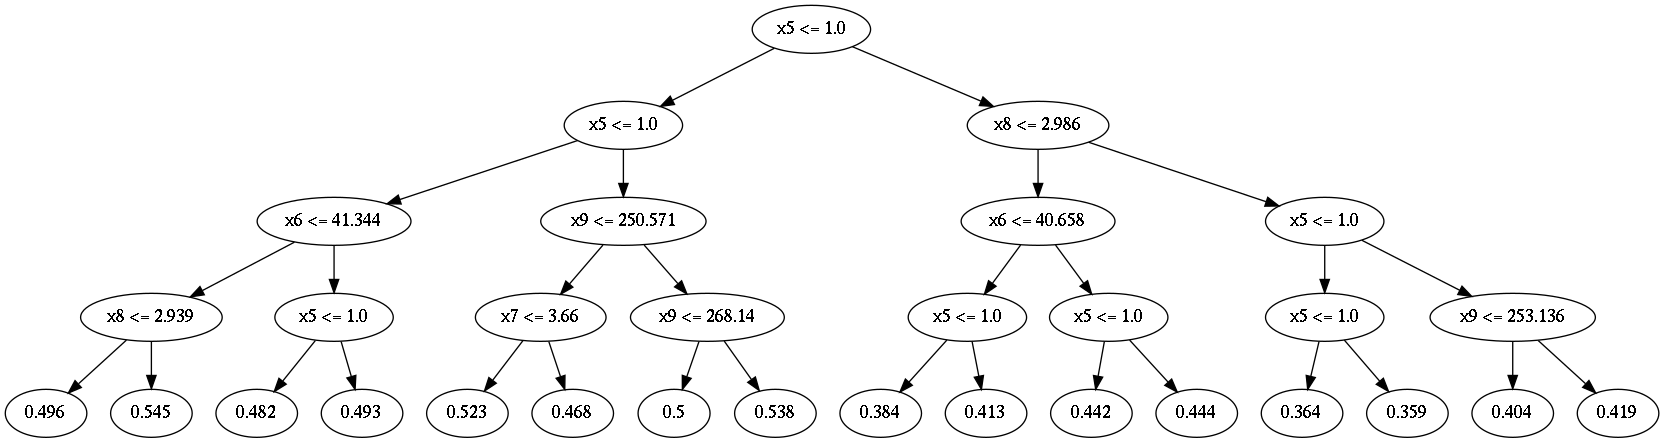

In [80]:
#%autoreload 2
image, nodes = anytree_decision_tree_from_parameters(test_network_dt_inet, config=config, normalizer_list=normalizer_list)
image
#tree.show()

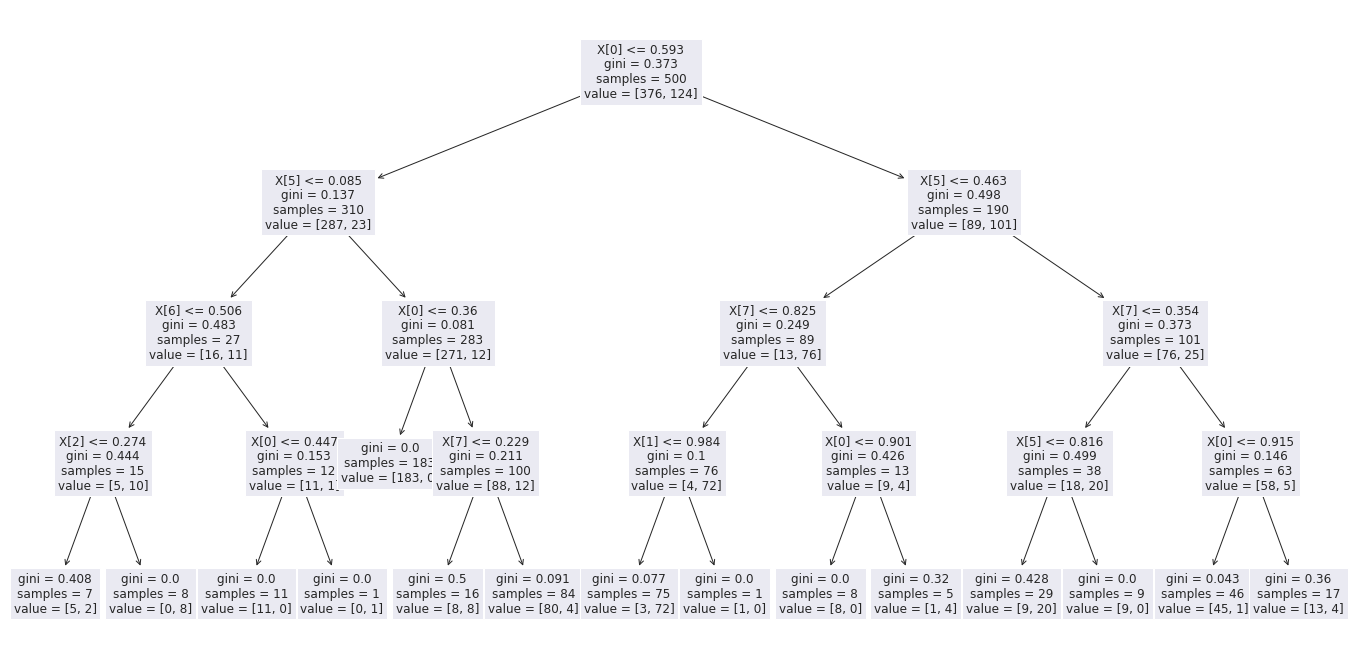

In [81]:
plt.figure(figsize=(24,12))  # set plot size (denoted in inches)
plot_tree(dt_sklearn_distilled, fontsize=12)
plt.show()

In [82]:
y_test_test_network_pred[:50].ravel()

array([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.],
      dtype=float32)

In [83]:
y_test_distilled_sklearn_dt[:50].ravel()

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0])

In [84]:
np.round(y_test_inet_dt[:50]).ravel()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

## NEXT DATASET